### Grading Feedback Cell
- **48/50**
- **Decomposition into distinct sections could have been better** 

In [ ]:
%%bash
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark
pip install seaborn

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=e0607455b85c9288f0e792b5397777edf7b496d76d0d27019cf3995c5c0c66cf
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml import feature
import re
from pyspark.sql import functions as fn
from pyspark.sql.functions import col, regexp_replace, split
from pyspark.sql.utils import AnalysisException
from pyspark.sql import Row
from pyspark.sql.types import IntegerType, DateType, FloatType, BooleanType
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

from pyspark.sql.functions import col, udf
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import create_map, lit
from itertools import chain
from pyspark.mllib import numpy as np
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder
import sklearn.metrics

enable_grid_search = False
data_cleaned = True
enable_grid = False

In [ ]:
if data_cleaned == False:
  sampled_df = spark.read.format("csv").option("header", "true").option('inferSchema','true').load("drive/Shared drives/IST 718 Group1/sampled_used_cars_data_nodesc.csv")

  new_car_logic = (sampled_df["is_new"] == 0)
  sampled_df = sampled_df[new_car_logic]
  sampled_df = sampled_df.drop(*['is_new'])

  # EDA: Duplicate Data Removal
  sampled_df = sampled_df.distinct()

  # Drop the index column
  # Drop exterior color ,power, and wheel system displacement (redundant columns)
  # Drop Bed height (no values)
  sampled_df = sampled_df.drop(*['power','main_picture_url',
                                'combine_fuel_economy', 'listing_id',
                                'vehicle_damage_category','trimId',
                                'trim_name','exterior_color',
                                'wheel_system_display','bed_height','power'])

  # Develop logic to scope data to vehicles priced under 90,000
  price_outlier_logic = (sampled_df["price"] < 90001)
  sampled_df = sampled_df[price_outlier_logic]

  # Generate of list of column names for future use
  colList = sampled_df.columns
  numColList = []
  catColList = []

  #Needs to occur prior to data type casting as the loop will convert columns back to strings
  for x in sampled_df.columns:
    sampled_df = sampled_df.withColumn(x, regexp_replace(col(x),r'--',''))
    sampled_df = sampled_df.withColumn(x, regexp_replace(col(x),r'None',''))

  #Column cleaning and type casting
  sampled_df = sampled_df.withColumn('back_legroom',
                                    regexp_replace(col('back_legroom'),
                                                    r'\sin',''))
  sampled_df = sampled_df.withColumn('front_legroom',
                                    regexp_replace(col('front_legroom'),
                                                    r'\sin',''))
  sampled_df = sampled_df.withColumn('front_legroom',
                                    fn.translate('front_legroom','0',''))
  sampled_df = sampled_df.withColumn('height',
                                    regexp_replace(col('height'),
                                                    r'\sin',''))
  sampled_df = sampled_df.withColumn('length',
                                    regexp_replace(col('length'),
                                                    r'\sin',''))
  sampled_df = sampled_df.withColumn('wheelbase',
                                    regexp_replace(col('wheelbase'),
                                                    r'\sin',''))
  sampled_df = sampled_df.withColumn('width',
                                    regexp_replace(col('width'),
                                                    r'\sin',''))
  sampled_df = sampled_df.withColumn('bed_length',
                                    regexp_replace(col('bed_length'),
                                                    r'\sin',''))
  sampled_df = sampled_df.withColumn('engine_cylinders',
                                    regexp_replace(col('engine_cylinders'),
                                                    r'[a-zA-Z]',''))
  #Remove all digits from engine type
  sampled_df = sampled_df.withColumn('engine_type',
                                    regexp_replace(col('engine_type'),
                                                    r'\d',''))
  #Remove all alphabet characters following space
  sampled_df = sampled_df.withColumn('engine_type',
                                    regexp_replace(col('engine_type'),
                                                    r'\s[a-zA-Z]*',''))
  sampled_df = sampled_df.withColumn('maximum_seating',
                                    regexp_replace(col('maximum_seating'),
                                                    r'\sseats',''))
  sampled_df = sampled_df.withColumn('fuel_tank_volume',
                                    regexp_replace(col('fuel_tank_volume'),
                                                    r'\sgal',''))
  sampled_df = sampled_df.withColumn('major_options',
                                    regexp_replace(col('major_options'),
                                                    r"[\[]'",''))
  sampled_df = sampled_df.withColumn('major_options',
                                    regexp_replace(col('major_options'),
                                                    r"'[\]]",''))
  sampled_df = sampled_df.withColumn('major_options',
                                    regexp_replace(col('major_options'),
                                                    r"'",''))
  sampled_df = sampled_df.withColumn('transmission_display',
                                    regexp_replace(col('transmission_display'),
                                                    r"\D*",''))

  #Decompose Torque column 
  if has_column(sampled_df, 'torque'):
    split_torque = split(sampled_df['torque'],r'\slb-ft\s@')
    sampled_df = sampled_df.withColumn('torque_ftlb',split_torque.getItem(0))
    sampled_df = sampled_df.withColumn('torque_rpm',split_torque.getItem(1))
    #Drop now redundant torque column
    sampled_df = sampled_df.drop('torque')

  #Remove all non digit charaters
  sampled_df = sampled_df.withColumn('torque_rpm',
                                    regexp_replace(col('torque_rpm'),'\D*',''))
  #Calculate new torque grade column
  sampled_df = sampled_df.withColumn('torque_grade',
                                    sampled_df.torque_ftlb/sampled_df.torque_rpm)

  #Recast column data types
  #Integer type loop
  integer_cols = ['engine_displacement','engine_cylinders','daysonmarket',
                  'horsepower','maximum_seating','mileage','owner_count',
                  'savings_amount','transmission_display','year',
                  'torque_ftlb','torque_rpm']
  for i in integer_cols:
    sampled_df = sampled_df.withColumn(i, sampled_df[i].cast(IntegerType()))

  #FloatType loop
  float_cols = ['back_legroom','front_legroom','city_fuel_economy',
                'bed_length','fuel_tank_volume','latitude','height',
                'highway_fuel_economy','length','longitude','price',
                'seller_rating','wheelbase','width','torque_grade']
  for i in float_cols:
    sampled_df = sampled_df.withColumn(i, sampled_df[i].cast(FloatType()))

  #DateType Loop
  date_cols = ['listed_date']
  for i in date_cols:
    sampled_df = sampled_df.withColumn(i, sampled_df[i].cast(DateType()))

  #Boolean Loop
  bool_cols = ['fleet','frame_damaged','franchise_dealer',
              'has_accidents','isCab','is_certified',
              'is_cpo','is_oemcpo','salvage','theft_title']
  for i in bool_cols:
    sampled_df = sampled_df.withColumn(i, sampled_df[i].cast(BooleanType()))

  #NA Handeling
  #Set empty booleans values to false (assume no report = negative condition)
  sampled_df = sampled_df.na.fill(False, ['is_cpo','is_oemcpo',
                                          'frame_damaged','fleet','isCab',
                                          'has_accidents','salvage',
                                          'theft_title'])

  sampled_df = sampled_df.na.fill(0, "back_legroom")
  sampled_df = sampled_df.na.fill('Gasoline', "fuel_type")
  sampled_df = sampled_df.na.fill('SUV / Crossover', "body_type")
  sampled_df = sampled_df.na.fill('A', "transmission")

  #Consolidate Dual clutch transmissions into automatic category
  sampled_df = sampled_df.withColumn('transmission',
                                    fn.when(col('transmission') == 'Dual Clutch','A').otherwise(col('transmission')))
      
      #fn.translate('transmission',"Dual Clutch",'A'))

  sampled_df = sampled_df.na.fill('FWD', "wheel_system")

  #Consolidate Wheel system type 4x2 in RWD drive category
  sampled_df = sampled_df.withColumn('wheel_system',
                                    fn.translate('wheel_system',"4X2","RWD"))

  #Use Spark imputer transform to replace NAs with median values of specified columns
  median_replace_col = ['owner_count','engine_cylinders','engine_displacement',
                        'horsepower','maximum_seating','mileage',
                        'transmission_display','torque_ftlb',
                        'torque_rpm','torque_grade']
  na_replace_with_median = feature.Imputer(strategy='median',
                                          inputCols=median_replace_col,
                                          outputCols=median_replace_col).fit(sampled_df)
  sampled_df = na_replace_with_median.transform(sampled_df)

  #Use Spark imputer transform to replace NAs with mean values of specified columns
  mean_replace_col = ['city_fuel_economy','front_legroom','fuel_tank_volume',
                      'highway_fuel_economy','seller_rating',
                      'wheelbase','height','length','width']
  na_replace_with_mean = feature.Imputer(strategy='mean', inputCols=mean_replace_col, outputCols=mean_replace_col).fit(sampled_df)
  sampled_df = na_replace_with_mean.transform(sampled_df)

  #Conditional engine type fill if cylinders =6-12 then v type, if < 6 I type
  sampled_df = sampled_df.withColumn('engine_type',
                                    fn.when(col('engine_cylinders').isin([6,8,10,12]) & fn.isnull(col('engine_type')),
                                            'V').otherwise(col('engine_type')))
  sampled_df = sampled_df.withColumn('engine_type',
                                    fn.when((col('engine_cylinders') < 6) & fn.isnull(col('engine_type')),
                                            'I').otherwise(col('engine_type')))
  #Any remaining engine_type NAs get filled in with I
  sampled_df = sampled_df.na.fill('I', "engine_type")

  # ordinal dictionary definitions
  bed_dict = {'Short':1,
              'Regular':2,
              'Long':3}

  body_dict = {'Coupe':1,
              'Convertible':2,
              'Hatchback':3,
              'Sedan':4,
              'Wagon':5,
              'SUV / Crossover':6,
              'Minivan':7,
              'Van':8,
              'Pickup Truck':9}

  cabin_dict = {'Regular Cab':1,
                'Extended Cab':2,
                'Crew Cab':3,
                'Large Crew Cab':4}

  engine_type_dict = {'I':1,
                      'R':2,
                      'H':3,
                      'V':4,
                      'W':5}

  fuel_type_dict = {'Propane':1,
                    'Compressed Natural Gas':2,
                    'Gasoline':3,
                    'Flex Fuel Vehicle':4,
                    'Biodiesel':5,
                    'Diesel':6,
                    'Hybrid':7,
                    'Electric':8}

  trans_dict = {'M':1,
                'CVT':2,
                'A':3}

  wheel_system_dict = {'FWD':1,
                      'RWD':2,
                      'AWD':3}

  # create maps
  bed_map = create_map([lit(x) for x in chain(*bed_dict.items())])
  body_map = create_map([lit(x) for x in chain(*body_dict.items())])
  cabin_map = create_map([lit(x) for x in chain(*cabin_dict.items())])
  engine_type_map = create_map([lit(x) for x in chain(*engine_type_dict.items())])
  fuel_type_map = create_map([lit(x) for x in chain(*fuel_type_dict.items())])
  trans_map = create_map([lit(x) for x in chain(*trans_dict.items())])
  wheel_system_map = create_map([lit(x) for x in chain(*wheel_system_dict.items())])

  # applying literal mapping
  sampled_df = sampled_df.withColumn('n_bed',bed_map[sampled_df['bed']])
  sampled_df = sampled_df.withColumn('n_body_type',body_map[sampled_df['body_type']])
  sampled_df = sampled_df.withColumn('n_cabin',cabin_map[sampled_df['cabin']])
  sampled_df = sampled_df.withColumn('n_engine_type',engine_type_map[sampled_df['engine_type']])
  sampled_df = sampled_df.withColumn('n_fuel_type',fuel_type_map[sampled_df['fuel_type']])
  sampled_df = sampled_df.withColumn('n_transmission',trans_map[sampled_df['transmission']])
  sampled_df = sampled_df.withColumn('n_wheel_system',wheel_system_map[sampled_df['wheel_system']])

  # Use string indexer on cols which do not require ordinal
  encoder = StringIndexer(inputCols=['city','dealer_zip','franchise_make',
                                    'interior_color','listing_color','make_name',
                                    'model_name','sp_name'],
                          outputCols=['n_city','n_dealer_zip','n_franchise_make',
                                      'n_interior_color','n_listing_color','n_make_name',
                                      'n_model_name','n_sp_name'],
                          handleInvalid='keep')

  sampled_df = encoder.fit(sampled_df).transform(sampled_df)

In [ ]:
sampled_df = spark.read.format("csv").option("header", "true").option('inferSchema','true').load("drive/Shared drives/IST 718 Group1/thecorrectstuff.csv")

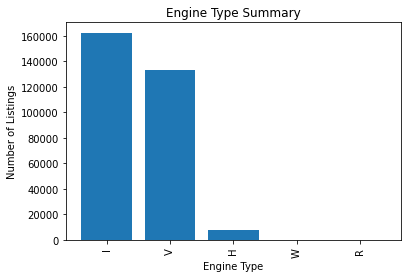

In [ ]:
engine_type_count_df = sampled_df.groupBy('engine_type').count().orderBy(fn.desc('count')).dropna().toPandas()

plt.bar(engine_type_count_df['engine_type'],engine_type_count_df['count'])
plt.xticks(rotation='vertical')
plt.xlabel('Engine Type')
plt.ylabel('Number of Listings')
plt.title('Engine Type Summary')
plt.show()

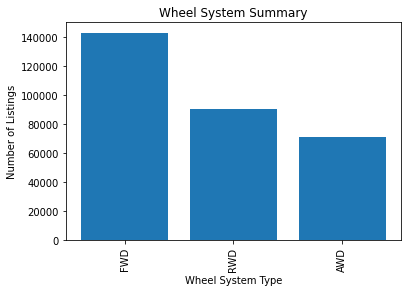

In [ ]:
wheel_system_count_df = sampled_df.groupBy('wheel_system').count().orderBy(fn.desc('count')).dropna().toPandas()

plt.bar(wheel_system_count_df['wheel_system'],wheel_system_count_df['count'])
plt.xticks(rotation='vertical')
plt.xlabel('Wheel System Type')
plt.ylabel('Number of Listings')
plt.title('Wheel System Summary')
plt.show()

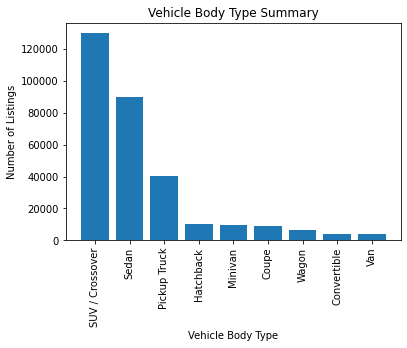

In [ ]:
body_count_df = sampled_df.groupBy('body_type').count().orderBy(fn.desc('count')).dropna().toPandas()

plt.bar(body_count_df['body_type'],body_count_df['count'])
plt.xticks(rotation='vertical')
plt.xlabel('Vehicle Body Type')
plt.ylabel('Number of Listings')
plt.title('Vehicle Body Type Summary')
plt.show()

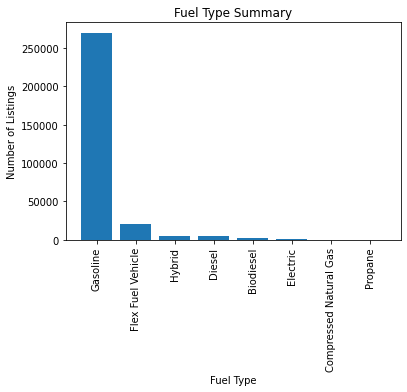

In [ ]:
fuel_type_df = sampled_df.groupBy('fuel_type').count().orderBy(fn.desc('count')).dropna().toPandas()

plt.bar(fuel_type_df['fuel_type'],fuel_type_df['count'])
plt.xticks(rotation='vertical')
plt.xlabel('Fuel Type')
plt.ylabel('Number of Listings')
plt.title('Fuel Type Summary')
plt.show()

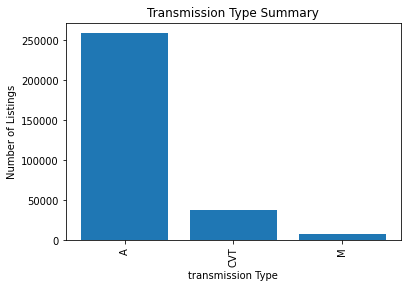

In [ ]:
transmission_df = sampled_df.groupBy('transmission').count().orderBy(fn.desc('count')).dropna().toPandas()

plt.bar(transmission_df['transmission'],transmission_df['count'])
plt.xticks(rotation='vertical')
plt.xlabel('transmission Type')
plt.ylabel('Number of Listings')
plt.title('Transmission Type Summary')
plt.show()

In [ ]:
sampled_df.select('price','city_fuel_economy','daysonmarket','horsepower','mileage').describe().toPandas()

,summary,price,city_fuel_economy,daysonmarket,horsepower,mileage
0,count,303798,303798,303798,303798,303798
1,mean,22044.00912431615,21.879087351476155,57.29375111093555,245.83771782566046,58462.16224925773
2,stddev,12431.114031164112,7.667139051357042,103.83041502536523,84.10438283393302,47311.1586769538
3,min,165.0,8.0,0,67,50
4,max,89999.0,127.0,2979,797,399900


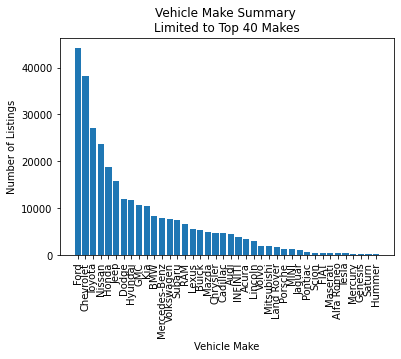

In [ ]:
make_count_df = sampled_df.groupBy('make_name').count().orderBy(fn.desc('count')).limit(40).toPandas()

plt.bar(make_count_df['make_name'],make_count_df['count'])
plt.xticks(rotation='vertical')
plt.xlabel('Vehicle Make')
plt.ylabel('Number of Listings')
plt.title('Vehicle Make Summary \nLimited to Top 40 Makes')
plt.show()

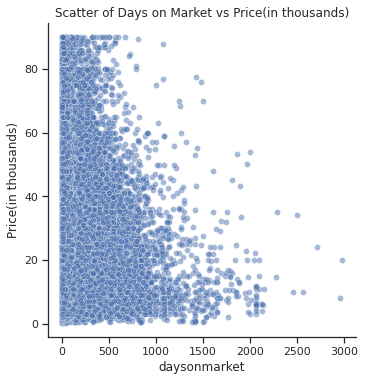

In [ ]:
# Scatter of price and days on market
sns.set(style='ticks') # Set style


sampled_df = sampled_df.withColumn("Price(in thousands)", (sampled_df['price'] / 1000))


n1 = sns.relplot(data = sampled_df.toPandas(),
                 x = "daysonmarket",
                 y = "Price(in thousands)",
                 alpha = 0.5) #set plotting parameters

n1.ax.xaxis.grid(True, "minor", linewidth=.25)
n1.ax.yaxis.grid(True, "minor", linewidth=.25)
#sns.plt.ticklabel_format(style = 'plain', axis = "y", useOffset = False)
n1.ax.set_title("Scatter of Days on Market vs Price(in thousands)")
n1.fig.set_size_inches(5,5)
display(n1)

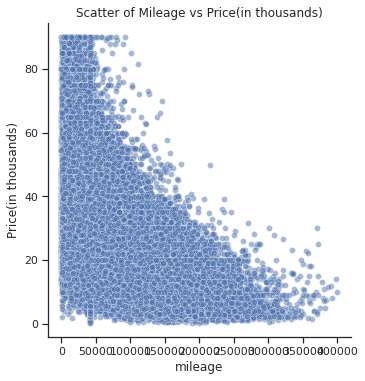

In [ ]:
n3 = sns.relplot(data = sampled_df.toPandas(),
                 x = "mileage",
                 y = "Price(in thousands)",
                 alpha = 0.5) #set plotting parameters

n3.ax.xaxis.grid(True, "minor", linewidth=.25)
n3.ax.yaxis.grid(True, "minor", linewidth=.25)
n3.ax.set_title("Scatter of Mileage vs Price(in thousands)")
n3.fig.set_size_inches(5,5)
display(n3)

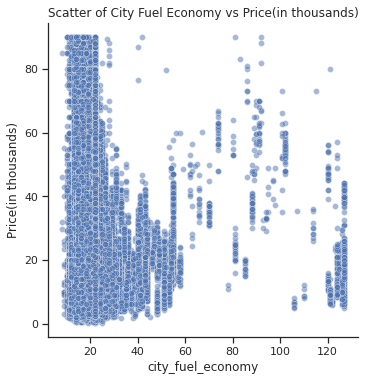

In [ ]:
n2 = sns.relplot(data = sampled_df.toPandas(),
                 x = "city_fuel_economy",
                 y = "Price(in thousands)",
                 alpha = 0.5) #set plotting parameters

n2.ax.xaxis.grid(True, "minor", linewidth=.25)
n2.ax.yaxis.grid(True, "minor", linewidth=.25)
n2.ax.set_title("Scatter of City Fuel Economy vs Price(in thousands)")
n2.fig.set_size_inches(5,5)
display(n2)

In [ ]:
print("Number of Observations:",sampled_df.count())
print("Number of Columns:",len(sampled_df.columns))

Number of Observations: 303798
Number of Columns: 115


In [ ]:
new_df = spark.read.format("csv").option("header", "true").option('inferSchema','true').load("drive/Shared drives/IST 718 Group1/thecorrectstuff.csv")

In [ ]:
# EDA: Dimension Inspection
print("Number of Observations:",new_df.count())
print("Number of Columns:",len(new_df.columns))

Number of Observations: 303798
Number of Columns: 114


In [ ]:
reg_df = new_df
reg_df = reg_df.drop(*['latitude', 'listed_date', 'listing_color', 'longitude','city', 'dealer_zip','interior_color','sp_name','sp_id'])
reg_df = reg_df.withColumn('HasAccidents',fn.when(col('has_accidents') == 'True', 1).otherwise(0))
reg_df = reg_df.drop('has_accidents')
 
reg_df = reg_df.withColumn('frameDamaged',fn.when(col('frame_damaged') == 'True', 1).otherwise(0))
reg_df = reg_df.drop('frame_damaged')
 
reg_df = reg_df.withColumn('franchiseDealer',fn.when(col('franchise_dealer') == 'True', 1).otherwise(0))
reg_df = reg_df.drop('franchise_dealer')
 
reg_df = reg_df.withColumn('isCabNew',fn.when(col('isCab') == 'True', 1).otherwise(0))
reg_df = reg_df.drop('isCab')
 
reg_df = reg_df.withColumn('isCpo',fn.when(col('is_cpo') == 'True', 1).otherwise(0))
reg_df = reg_df.drop('is_cpo')
 
#reg_df = reg_df.withColumn('isNew',fn.when(col('is_new') == 'True', 1).otherwise(0))
#reg_df = reg_df.drop('is_new')
 
reg_df = reg_df.withColumn('isOemcpo',fn.when(col('is_oemcpo') == 'True', 1).otherwise(0))
reg_df = reg_df.drop('is_oemcpo')
 
reg_df = reg_df.withColumn('Salvage',fn.when(col('salvage') == 'True', 1).otherwise(0))
reg_df = reg_df.drop('salvage')
 
reg_df = reg_df.withColumn('theftTitle',fn.when(col('theft_title') == 'True', 1).otherwise(0))
reg_df = reg_df.drop('theft_title')

reg_df = reg_df.withColumn('length_category',fn.when(col('length') < 176.4, "compact").when(col("length") > 187.2, "fullsize").otherwise('midsize'))
reg_df = reg_df.withColumn('width_category',fn.when(col('width') < 70.9, "narrow").when(col("width") > 74.8, "wide").otherwise("regular"))
reg_df = reg_df.withColumn('age',2020 - (col('year')))

from pyspark.ml import feature, Pipeline #import modules/packages for the entire process
# create ordinal pipline for select features
ord_cat_feat_eng_pipe = Pipeline(stages=[feature.StringIndexerModel.from_labels(['compact','midsize','fullsize'],
                                                                                handleInvalid = "keep", 
                                                                                inputCol="length_category",
                                                                                outputCol="length_category_idx"),
                                         feature.StringIndexerModel.from_labels(['narrow','regular','wide'],
                                                                                handleInvalid = "keep",
                                                                                inputCol="width_category",
                                                                                outputCol="width_category_idx")])

reg_df = ord_cat_feat_eng_pipe.fit(reg_df).transform(reg_df)

# Develop logic to scope out new cars 
#new_car_logic = (reg_df["isNew"] == 0)
#reg_df = reg_df[new_car_logic]

In [ ]:
# skip this cell for now, too long
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

training_df, validation_df = reg_df.randomSplit([0.7, 0.3],
                                                seed=42)
# originals
#rf_cols = ['back_legroom','city_fuel_economy',
#           'daysonmarket','engine_cylinders','engine_displacement','fleet',
#           'frame_damaged','franchise_dealer','front_legroom',
#           'fuel_tank_volume','has_accidents','height',
#           'highway_fuel_economy','horsepower','isCab',
#           'is_cpo','is_oemcpo','length','maximum_seating','mileage',
#           'owner_count','salvage','savings_amount','seller_rating',
#           'theft_title','transmission_display','wheelbase','width','year',
#           'torque_ftlb','torque_rpm','torque_grade','n_body_type',
#           'n_engine_type','n_transmission','n_wheel_system','n_city',
#           'n_make_name','n_franchise_make','n_sp_name','n_interior_color',
#           'n_model_name','n_listing_color','n_fuel_type']

rf_cols = ["length_category_idx","width_category_idx","n_body_type",
           "n_engine_type","n_fuel_type","n_make_name","n_franchise_make",
           "n_model_name","n_transmission","n_wheel_system","age",
           "city_fuel_economy", "highway_fuel_economy","daysonmarket",
           "engine_cylinders", "horsepower","mileage","owner_count",
           "maximum_seating", "engine_displacement", "torque_ftlb"]

rf_vec = VectorAssembler(inputCols=rf_cols, outputCol='features')
rf = RandomForestRegressor(featuresCol='features', labelCol='price', maxBins=4482)

if enable_grid == True:
  paramGrid = ParamGridBuilder().\
  addGrid(rf.numTrees, np.arange(20,121,20)).\
  addGrid(rf.maxDepth, np.arange(13,14,2)).\
  build()

  rf_pipe = Pipeline(stages = [rf_vec,rf])

  all_models = []
  for j in range(len(paramGrid)):
    print("Fitting model {}".format(j+1))
    model = rf_pipe.fit(training_df, paramGrid[j])
    all_models.append(model)
        
  scores =[]
  print('Model fitting complete -> Evaluating Scores')
  for m in all_models:
    score_rf_pipe_1 = RegressionEvaluator(labelCol='price',metricName='rmse').evaluate(m.transform(validation_df))
    scores.append(score_rf_pipe_1)
          
  print(min(scores), '\n', paramGrid[scores.index(min(scores))])

# with grid searched params
rf_vec = VectorAssembler(inputCols=rf_cols, outputCol='features')
rf = RandomForestRegressor(numTrees=100,
                           maxDepth=11,
                           featuresCol='features',
                           labelCol='price',
                           maxBins=4482)

rf_pipe = Pipeline(stages=[rf_vec,rf])

model = rf_pipe.fit(training_df)

score_rf_pipe_1 = RegressionEvaluator(labelCol='price',
                                      metricName='rmse').evaluate(model.transform(validation_df))

score_rf_pipe_1

3825.5214493392477

In [ ]:
feats = zip(rf_cols,list(model.stages[-1].featureImportances))
feats_df = pd.DataFrame(feats,columns=['Feature','Importance %'])
feats_df.sort_values('Importance %',ascending=False).head(30)

,Feature,Importance %
15,horsepower,0.269163
10,age,0.201501
16,mileage,0.152224
20,torque_ftlb,0.116023
9,n_wheel_system,0.039281
19,engine_displacement,0.031494
1,width_category_idx,0.026184
17,owner_count,0.022601
5,n_make_name,0.022485
7,n_model_name,0.022053


In [ ]:
predictions = model.transform(validation_df)
y_pred = [row[0] for row in predictions.select('prediction').collect()]
y_true = [row[0] for row in predictions.select('price').collect()]

import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {:4.3f}'.format(r2_score))

r2_score: 0.905


In [ ]:
pc_rf_cols = ["pc1","pc2","pc3","pc4","pc5","pc6","pc7","pc8","pc9","pc10",
              "pc11","pc12","pc13", "pc14", "pc15","pc16","pc17","pc18",
              "pc19","pc20","pc21","pc22","pc23", "pc24","pc25","pc26","pc27",
              "pc28","pc29","pc25","pc30","pc31","pc32","pc33","pc34","pc35"]

pc_rf_vec = VectorAssembler(inputCols=pc_rf_cols, outputCol='pc_features')
pc_rf = RandomForestRegressor(featuresCol='pc_features',
                              labelCol='price',
                              maxBins=4482)
if enable_grid == True:  
  paramGrid = ParamGridBuilder().\
  addGrid(rf.numTrees, np.arange(20,81,20)).\
  addGrid(rf.maxDepth, np.arange(3,6,2)).\
  build()

  pc_rf_pipe = Pipeline(stages = [pc_rf_vec,pc_rf])

  all_models_pc = []
  for j in range(len(paramGrid)):
    print("Fitting model {}".format(j+1))
    model = pc_rf_pipe.fit(training_df, paramGrid[j])
    all_models_pc.append(model)
          
  scores_pc =[]
  print('Model fitting complete -> Evaluating Scores')
  for m in all_models_pc:
    score_rf_pipe_1 = RegressionEvaluator(labelCol='price',metricName='rmse').evaluate(m.transform(validation_df))
    scores_pc.append(score_rf_pipe_1)
            
  print(min(scores_pc), '\n', paramGrid[scores_pc.index(min(scores_pc))])

pc_rf_vec = VectorAssembler(inputCols=pc_rf_cols, outputCol='pc_features')
pc_rf = RandomForestRegressor(numTrees=20,
                           maxDepth=3,
                           featuresCol='pc_features',
                           labelCol='price',
                           maxBins=4482)

pc_rf_pipe = Pipeline(stages=[pc_rf_vec,pc_rf])

pc_model = pc_rf_pipe.fit(training_df)

pc_score_rf_pipe_1 = RegressionEvaluator(labelCol='price',
                                         metricName='rmse').evaluate(pc_model.transform(validation_df))

pc_score_rf_pipe_1

7164.488545941881

In [ ]:
pc_predictions = pc_model.transform(validation_df)
pc_y_pred = [row[0] for row in pc_predictions.select('prediction').collect()]
pc_y_true = [row[0] for row in pc_predictions.select('price').collect()]

import sklearn.metrics
pc_r2_score = sklearn.metrics.r2_score(pc_y_true, pc_y_pred)
print('r2_score: {:4.3f}'.format(pc_r2_score))

r2_score: 0.667


In [ ]:
# Create a Pipeline to transform feature that will be modeled
tot_feat_eng_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=["length_category_idx","width_category_idx","n_body_type",
                                                                        "n_engine_type","n_fuel_type","n_make_name",
                                                                        "n_franchise_make","n_model_name","n_transmission",
                                                                        "n_wheel_system","age", "city_fuel_economy",
                                                                        "highway_fuel_economy","daysonmarket","engine_cylinders",
                                                                        "horsepower","mileage","owner_count", "maximum_seating",
                                                                        "engine_displacement", "torque_ftlb"],
                                                              outputCol = 'features'),
                                     feature.StandardScaler(withMean = False,
                                                            inputCol="features",
                                                            outputCol="scaledFeatures")])

reg_df_prepped = tot_feat_eng_pipe.fit(reg_df).transform(reg_df)

enable_grid_search = False

from pyspark.ml import regression, evaluation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

if enable_grid_search:
  
  #Create a Regressor estimator
  lr = regression.LinearRegression(featuresCol='scaledFeatures', labelCol='price')

  #Establish the grid
  paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0.01, 0.02, 0.03, 0.4, 0.7])\
    .addGrid(lr.elasticNetParam, [0.0, 0.2, 0.4, 0.5, 0.7])\
    .build()
    
  # Establish the evaluator
  evaluator = RegressionEvaluator()\
                .setMetricName("mse")\
                .setLabelCol("price")\
                .setPredictionCol("prediction")                

  #Establish the Cross Validation
  cv = CrossValidator()\
    .setEstimator(lr)\
    .setEstimatorParamMaps(paramGrid)\
    .setEvaluator(evaluator)\
    .setNumFolds(3)

  cv_final_model_fitted = cv.fit(reg_df_prepped)

 
  print("The resulting scores from 3-folds cross validation on the data: ", cv_final_model_fitted.avgMetrics)
  print("The lowest score from 3-folds cross validation on the data: ", min(cv_final_model_fitted.avgMetrics))

# Now we'll partition the data
training_reg_df_prepped , testing_reg_df_prepped = reg_df_prepped.randomSplit([0.7, 0.3])

from pyspark.ml import regression, evaluation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

#Create a Regressor estimator
lr_tuned = regression.LinearRegression(featuresCol='scaledFeatures',
                                       labelCol='price',
                                       elasticNetParam=0.4,
                                       regParam=0.03)

# Create the model and preditions
trainModel = lr_tuned.fit(training_reg_df_prepped)

predicitons = trainModel.transform(testing_reg_df_prepped)

# Establish the evaluator
evaluator = RegressionEvaluator()\
  .setMetricName("mse")\
  .setLabelCol("price")\
  .setPredictionCol("prediction") 

TestMSE = evaluator.evaluate(trainModel.transform(testing_reg_df_prepped))

print("Test data MSE :", TestMSE)

Test data MSE : 46204414.62807857


In [ ]:
# Based on what we learned above, lets review some of the important statistics
trainingSummary = trainModel.summary
print("Fit model values")
print("********************")
print("MSE: %f" % round(trainingSummary.meanSquaredError))
print("r2: %f" % trainingSummary.r2)
print("Explained Variance: %f" % round(trainingSummary.explainedVariance))

print("********************")
print("Test data MSE :", round(TestMSE))

Fit model values
********************
MSE: 45711907.000000
r2: 0.703684
Explained Variance: 108563862.000000
********************
Test data MSE : 46204415


In [ ]:
# Inspect the coeficients
Coefficients = trainModel.coefficients
Coefficients

DenseVector([90.0158, 19.783, 1165.4293, -1530.3828, 38.4697, 554.7093, -564.0053, 1005.6183, -359.4193, 1178.0588, -1185.8538, 538.7951, -440.347, 11.3578, 1836.1062, 6646.0075, -5117.8271, -828.0625, -5.2781, -1935.3526, 1442.824])

In [ ]:
#Create a Regressor estimator
lr_tuned2 = regression.LinearRegression(featuresCol='scaledFeatures', labelCol='price', elasticNetParam=0, regParam=0.03, solver='normal')

# Create the model and preditions
trainModel2 = lr_tuned2.fit(training_reg_df_prepped)

predicitons2 = trainModel2.transform(testing_reg_df_prepped)

# Establish the evaluator
evaluator2 = RegressionEvaluator()\
  .setMetricName("mse")\
  .setLabelCol("price")\
  .setPredictionCol("prediction") 

TestMSE2 = evaluator2.evaluate(trainModel2.transform(testing_reg_df_prepped))

print("Test data MSE :", TestMSE2)

Test data MSE : 46205710.712729774


In [ ]:
# Based on what we learned above, lets review some of the important statistics
trainingSummary2 = trainModel2.summary
print("Fit model values")
print("********************")
print("MSE: %f" % round(trainingSummary2.meanSquaredError))
print("r2: %f" % trainingSummary2.r2)
print("Explained Variance: %f" % round(trainingSummary2.explainedVariance))

print("********************")
print("Test data MSE :", round(TestMSE2))

Fit model values
********************
MSE: 45711839.000000
r2: 0.703684
Explained Variance: 108555101.000000
********************
Test data MSE : 46205711


In [ ]:
#Run this custom funciton to provide an organized output
def modelsummary(model):
    import numpy as np
    print ("Note: the last rows are the information for Intercept")
    print ("##","-------------------------------------------------")
    print ("##","  Estimate   |   Std.Error | t Values  |  P-value")
    coef = np.append(list(model.coefficients),model.intercept)
    Summary=model.summary

    for i in range(len(Summary.pValues)):
        print ("##",'{:10.6f}'.format(coef[i]),\
        '{:10.6f}'.format(Summary.coefficientStandardErrors[i]),\
        '{:8.3f}'.format(Summary.tValues[i]),\
        '{:10.6f}'.format(Summary.pValues[i]))

    print ("##",'---')
    print ("##","Mean squared error: % .6f" \
           % Summary.meanSquaredError, ", RMSE: % .6f" \
           % Summary.rootMeanSquaredError )
    print ("##","Multiple R-squared: %f" % Summary.r2, ", \
            Total iterations: %i"% Summary.totalIterations)

In [ ]:
# Run the function
modelsummary(trainModel2)

Note: the last rows are the information for Intercept
## -------------------------------------------------
##   Estimate   |   Std.Error | t Values  |  P-value
##  92.763757  20.017724    4.634   0.000004
##  22.411789  21.035447    1.065   0.286683
## 1163.686383  20.384011   57.088   0.000000
## -1527.597020  32.002453  -47.734   0.000000
##  37.209379  19.346094    1.923   0.054437
## 555.148984  17.625555   31.497   0.000000
## -563.902136  15.906159  -35.452   0.000000
## 1006.332689  18.937378   53.140   0.000000
## -358.166353  15.741337  -22.753   0.000000
## 1178.516418  17.180560   68.596   0.000000
## -1186.282557  21.283314  -55.738   0.000000
## 546.345276  53.408810   10.229   0.000000
## -451.256669  55.368389   -8.150   0.000000
##  11.104289  14.969606    0.742   0.458216
## 1826.363008  45.742303   39.927   0.000000
## 6631.510050  39.243365  168.984   0.000000
## -5120.163617  20.968197 -244.187   0.000000
## -828.172262  18.028601  -45.937   0.000000
##  -7.753694  

In [ ]:
# Lets save these to variables
coeffs = trainModel2.coefficients.toArray()
coeffStandError = trainModel2.summary.coefficientStandardErrors
tValues = trainModel2.summary.tValues
pValues = trainModel2.summary.pValues
absCoeffs = abs(trainModel2.coefficients.toArray())
# Create a summary df
summary_df = pd.DataFrame(list(zip(["length_category_idx","width_category_idx","n_body_type","n_engine_type","n_fuel_type","n_make_name","n_franchise_make","n_model_name","n_transmission","n_wheel_system",
                                    "age", "city_fuel_economy", "highway_fuel_economy","daysonmarket","engine_cylinders", "horsepower","mileage",
                                    "owner_count", "maximum_seating", "engine_displacement", "torque_ftlb"],
                                   coeffs,coeffStandError,tValues,pValues,absCoeffs)),
                          columns = ["Feature", 'Coefficients', 'Coefficient_SE',
                                     'T_Values', "P_Values", "AbsValue_Coeffs" ]).sort_values("AbsValue_Coeffs",
                                                                                              ascending = False)
                                     
summary_df

,Feature,Coefficients,Coefficient_SE,T_Values,P_Values,AbsValue_Coeffs
15,horsepower,6631.510050,39.243365,168.984237,0.000000e+00,6631.510050
16,mileage,-5120.163617,20.968197,-244.187117,0.000000e+00,5120.163617
19,engine_displacement,-1919.129010,38.655656,-49.646785,0.000000e+00,1919.129010
14,engine_cylinders,1826.363008,45.742303,39.927220,0.000000e+00,1826.363008
3,n_engine_type,-1527.597020,32.002453,-47.733748,0.000000e+00,1527.597020
20,torque_ftlb,1445.118145,27.590385,52.377601,0.000000e+00,1445.118145
10,age,-1186.282557,21.283314,-55.737680,0.000000e+00,1186.282557
9,n_wheel_system,1178.516418,17.180560,68.595926,0.000000e+00,1178.516418
2,n_body_type,1163.686383,20.384011,57.088194,0.000000e+00,1163.686383
7,n_model_name,1006.332689,18.937378,53.140021,0.000000e+00,1006.332689


In [ ]:
# Create a Pipeline to transform features
pca_feat_eng_pipe = Pipeline(stages=[
    feature.VectorAssembler(inputCols=["pc1","pc2","pc3","pc4","pc5","pc6","pc7","pc8","pc9", "pc10","pc11", "pc12",
                                       "pc13", "pc14", "pc15","pc16","pc17","pc18","pc19","pc20","pc21","pc22","pc23", "pc24","pc25",
                                       "pc26","pc27","pc28","pc29","pc25","pc30","pc31","pc32","pc33","pc34","pc35"],
                             outputCol = 'features'),
                             feature.StandardScaler(withMean = False,
                                                    inputCol="features",
                                                    outputCol="scaledFeatures")])

# Fit and transform for PCA
reg_df_prepped_pca = pca_feat_eng_pipe.fit(reg_df).transform(reg_df)

from pyspark.ml import regression, evaluation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

if enable_grid_search:
  
  #Create a Regressor estimator
  lr_pca = regression.LinearRegression(featuresCol='scaledFeatures', labelCol='price')

  #Establish the grid
  paramGrid = ParamGridBuilder()\
    .addGrid(lr_pca.regParam, [0.0, 0.01, 0.02, 0.03, 0.4, 0.7])\
    .addGrid(lr_pca.elasticNetParam, [0.0, 0.2, 0.4, 0.5, 0.7])\
    .build()
    
  # Establish the evaluator
  evaluator = RegressionEvaluator()\
                .setMetricName("mse")\
                .setLabelCol("price")\
                .setPredictionCol("prediction")                

  #Establish the Cross Validation
  cv = CrossValidator()\
    .setEstimator(lr_pca)\
    .setEstimatorParamMaps(paramGrid)\
    .setEvaluator(evaluator)\
    .setNumFolds(3)

  cv_final_model_fitted_pca = cv.fit(reg_df_prepped_pca)

 
  print("The resulting scores from 3-folds cross validation on the data: ", cv_final_model_fitted_pca.avgMetrics)
  print("The lowest score from 3-folds cross validation on the data: ", min(cv_final_model_fitted_pca.avgMetrics))
  print("The best model is", cv_final_model_fitted_pca.bestModel)

  pass

In [ ]:
# Now we'll partition the data
training_reg_df_prepped_pca, testing_reg_df_prepped_pca = reg_df_prepped_pca.randomSplit([0.7, 0.3])
#Create a Regressor estimator with PCA
lr_pca_tuned2 = regression.LinearRegression(featuresCol='scaledFeatures', labelCol='price', elasticNetParam=0.5, regParam=0.03)

# Create the model and preditions
trainModel_pca = lr_pca_tuned2.fit(training_reg_df_prepped_pca)

predicitons_pca = trainModel_pca.transform(testing_reg_df_prepped_pca)

# Establish the evaluator
evaluator_pca = RegressionEvaluator()\
  .setMetricName("mse")\
  .setLabelCol("price")\
  .setPredictionCol("prediction") 

TestMSE3 = evaluator_pca.evaluate(trainModel_pca.transform(testing_reg_df_prepped_pca))

print("Test data MSE :", TestMSE3)

Test data MSE : 42730145.256368674


In [ ]:
# Based on what we learned above, lets review some of the important statistics
trainModel_pca_Summary = trainModel_pca.summary
print("Fit model values")
print("********************")
print("MSE: %f" % round(trainModel_pca_Summary.meanSquaredError))
print("r2: %f" % trainModel_pca_Summary.r2)
print("Explained Variance: %f" % round(trainModel_pca_Summary.explainedVariance))

print("********************")
print("Test data MSE :", round(TestMSE3))

Fit model values
********************
MSE: 44391498.000000
r2: 0.713770
Explained Variance: 110743833.000000
********************
Test data MSE : 42730145


In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
logreg_sampled_df =  new_df

#Convert boolean columns to integer to change from booleans to 0 and 1
#create list of boolena columns
bool_cols_input = ['fleet','frame_damaged','franchise_dealer','has_accidents','isCab','is_cpo','is_oemcpo','salvage','theft_title']
#Iterate through list and cast to integer type
for i in bool_cols_input:
  logreg_sampled_df = logreg_sampled_df.withColumn(i, logreg_sampled_df[i].cast(IntegerType()))

#Classifier imports and dataset split

training_df, validation_df, testing_df = logreg_sampled_df.randomSplit([0.6, 0.3, 0.1], seed=0)

#logistical Regression with Grid Search

#Create list of feature columns for use in vector assemeble
feature_cols = ['back_legroom','city_fuel_economy','daysonmarket','engine_cylinders','engine_displacement','frame_damaged','franchise_dealer','front_legroom',
                'fuel_tank_volume','has_accidents','height','highway_fuel_economy','horsepower','is_cpo','is_oemcpo','latitude','length',
                'longitude','maximum_seating','mileage','owner_count','price','salvage','savings_amount','seller_rating','theft_title','transmission_display',
                'wheelbase','width','year','torque_ftlb','torque_rpm','torque_grade','n_body_type','n_engine_type','n_fuel_type','n_transmission','n_wheel_system',
                'n_city','n_make_name','n_franchise_make','n_sp_name','n_interior_color','n_model_name','n_listing_color']

#Second preprocessing step to create feature vector and scale so feature coeffcients can be compared for importance
lr_va = feature.VectorAssembler(inputCols=feature_cols, outputCol='features')

scaler = feature.StandardScaler(withMean=True, inputCol='features')

logreg_preprocessing_2 = Pipeline(stages=[lr_va, scaler])

if enable_grid:
  lr = LogisticRegression(labelCol='fleet',featuresCol='features')

  grid = ParamGridBuilder().\
  addGrid(lr.regParam, [0., 0.01, 0.02]).\
  addGrid(lr.elasticNetParam, [0., 0.1, 0.3]).\
  build()

  lr_pipe = Pipeline(stages = [logreg_preprocessing_2,lr])

  all_models = []
  for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = lr_pipe.fit(training_df, grid[j])
    all_models.append(model)
      
  scores =[]
  print('Model fitting complete -> Evaluating Scores')
  for m in all_models:
    score_lr_pipe_1 = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderPR').evaluate(m.transform(validation_df))
    scores.append(score_lr_pipe_1)
        
  print(max(scores), '\n', grid[scores.index(max(scores))])
pass

#Feature Inference
if enable_grid:
  abs_feature_scores = [abs(i) for i in all_models[scores.index(max(scores))].stages[-1].coefficients.toArray().tolist()]
  df_col = ['feature','weight']
  abs_coeffs_df = spark.createDataFrame(data=zip(feature_cols,abs_feature_scores),schema = df_col)

  lr_important_features = abs_coeffs_df.sort(fn.desc('weight')).limit(10).toPandas()

  display(lr_important_features)

  feature_scores = all_models[scores.index(max(scores))].stages[-1].coefficients.toArray().tolist()
  coeffs_df = spark.createDataFrame(data=zip(feature_cols,feature_scores),schema = df_col)

  lr_features_pos = coeffs_df.sort(fn.desc('weight')).limit(10).toPandas()
  lr_features_neg = coeffs_df.sort('weight').limit(10).toPandas()

  display(lr_features_pos)
  display(lr_features_neg)
pass

#LR Optimized Model
alpha_par = 0.01
lambda_par = 0.1

lr = LogisticRegression(labelCol='fleet',featuresCol='features',regParam=lambda_par, elasticNetParam=alpha_par)

lr_pipe = Pipeline(stages = [logreg_preprocessing_2,lr])

opt_lr = lr_pipe.fit(training_df)

score_lr_pipe_1_pr = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderPR').evaluate(opt_lr.transform(validation_df))
score_lr_pipe_1_roc = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(opt_lr.transform(validation_df))

print(score_lr_pipe_1_pr)
print('AUC ROC: ',score_lr_pipe_1_roc)
print('AUC PR: ',score_lr_pipe_1_pr)

0.3916661698829387
AUC ROC:  0.7093040143632703
AUC PR:  0.3916661698829387


In [ ]:
feature_scores = opt_lr.stages[-1].coefficients.toArray().tolist()
abs_feature_scores = [abs(i) for i in opt_lr.stages[-1].coefficients.toArray().tolist()]

df_col = ['feature','weight','abs_weight']
abs_coeffs_df = pd.DataFrame({'feature': feature_cols,
                              'weight': feature_scores,
                              'abs_weight': abs_feature_scores})

lr_important_features = abs_coeffs_df.sort_values('abs_weight',ascending=False)

display(lr_important_features)

#feature_scores = opt_lr.stages[-1].coefficients.toArray().tolist()
#coeffs_df = spark.createDataFrame(data=zip(feature_cols,feature_scores),schema = df_col)

#lr_features_pos = coeffs_df.sort(fn.desc('weight')).toPandas()
#lr_features_neg = coeffs_df.sort('weight').toPandas()

#display(lr_features_pos)
#display(lr_features_neg)

,feature,weight,abs_weight
32,torque_grade,-5.728952e-01,5.728952e-01
22,salvage,-4.279974e-01,4.279974e-01
5,frame_damaged,3.523538e-01,3.523538e-01
13,is_cpo,-2.696671e-01,2.696671e-01
25,theft_title,2.476798e-01,2.476798e-01
20,owner_count,1.731422e-01,1.731422e-01
6,franchise_dealer,-1.689030e-01,1.689030e-01
37,n_wheel_system,-1.328398e-01,1.328398e-01
18,maximum_seating,1.249477e-01,1.249477e-01
9,has_accidents,-6.392782e-02,6.392782e-02


In [ ]:
rf_feature_cols = ['back_legroom','city_fuel_economy','daysonmarket',
                   'engine_cylinders','engine_displacement','frame_damaged',
                   'franchise_dealer','front_legroom','fuel_tank_volume',
                   'has_accidents','height','highway_fuel_economy',
                   'horsepower','is_cpo','is_oemcpo','latitude','length',
                   'longitude','maximum_seating','mileage','owner_count',
                   'price','salvage','savings_amount','seller_rating',
                   'theft_title','transmission_display','wheelbase',
                   'width','year','torque_ftlb','torque_rpm','torque_grade',
                   'n_body_type','n_engine_type','n_fuel_type',
                   'n_transmission','n_wheel_system','n_city',
                   'n_make_name','n_franchise_make','n_model_name',
                   'n_listing_color']

if enable_grid:
  rf_va = feature.VectorAssembler(inputCols=rf_feature_cols, outputCol='features')

  rf = RandomForestClassifier(featuresCol='features', labelCol='fleet', maxBins=4482)
  
  paramGrid = ParamGridBuilder().\
  addGrid(rf.numTrees, [20,30,40]).\
  addGrid(rf.maxDepth, [5,7,9]).\
  build()

  rf_pipe = Pipeline(stages = [rf_va,rf])

  all_models = []
  for j in range(len(paramGrid)):
    print("Fitting model {}".format(j+1))
    model = rf_pipe.fit(training_df, paramGrid[j])
    all_models.append(model)
      
  scores =[]
  print('Model fitting complete -> Evaluating Scores')
  for m in all_models:
    score_rf_pipe_1 = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderPR').evaluate(m.transform(validation_df))
    scores.append(score_rf_pipe_1)
        
  print(max(scores), '\n', paramGrid[scores.index(max(scores))])
  pass

  #Random Forest
maxdepth = 9
numtrees = 40

#Second preprocessing step to create feature vector and scale so feature coeffcients can be compared for importance
rf_va = feature.VectorAssembler(inputCols=rf_feature_cols, outputCol='features')

rf = RandomForestClassifier(featuresCol='features',
                            labelCol='fleet',
                            maxBins=4482,
                            numTrees = numtrees, 
                            maxDepth = maxdepth)

rf_pipe = Pipeline(stages = [rf_va,rf]).fit(training_df)

trans = rf_pipe.transform(validation_df)
score_rf_roc = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(trans)
score_rf_pr = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderPR').evaluate(trans)
print('AUC ROC: ',score_rf_roc)
print('AUC PR: ',score_rf_pr)

AUC ROC:  0.8947921211622768
AUC PR:  0.7557422160137878


In [ ]:
pd.DataFrame(list(zip(rf_feature_cols, rf_pipe.stages[-1].featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending=False)

,column,weight
29,year,0.410636
19,mileage,0.094283
20,owner_count,0.053432
21,price,0.036732
39,n_make_name,0.030363
31,torque_rpm,0.028032
16,length,0.024232
27,wheelbase,0.020224
33,n_body_type,0.019846
32,torque_grade,0.017910


In [ ]:
rf_preds = rf_pipe.transform(testing_df)
lr_preds = opt_lr.transform(testing_df)

preds_rf_rdd = rf_preds.select('fleet','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['fleet'])))
preds_lr_rdd = lr_preds.select('fleet','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['fleet'])))

In [ ]:
comp_score_rf_roc = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(rf_preds)
comp_score_rf_pr = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderPR').evaluate(rf_preds)

comp_score_lr_roc = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(lr_preds)
comp_score_lr_pr = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderPR').evaluate(lr_preds)


print('Random Forest AUC ROC Score:',comp_score_rf_roc,
      "\nRandom Forest AUC PR Score:",comp_score_rf_pr,
      "\n",
      "\nLinear Regression AUC ROC Score:",comp_score_lr_roc,
      "\nLinear Regression AUC PR Score:",comp_score_lr_pr)

Random Forest AUC ROC Score: 0.8973795998480467 
Random Forest AUC PR Score: 0.7628638948755296 
 
Linear Regression AUC ROC Score: 0.7094675468806151 
Linear Regression AUC PR Score: 0.393619642744205


In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

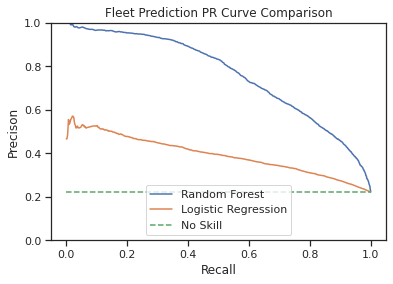

In [ ]:
points_rf_rdd_pr = CurveMetrics(preds_rf_rdd).get_curve('pr')
points_lr_rdd_pr = CurveMetrics(preds_lr_rdd).get_curve('pr')

x_val_rf = [x[0] for x in points_rf_rdd_pr]
y_val_rf = [x[1] for x in points_rf_rdd_pr]
plt.plot(x_val_rf, y_val_rf, label='Random Forest')

x_val_lr = [x[0] for x in points_lr_rdd_pr]
y_val_lr = [x[1] for x in points_lr_rdd_pr]
plt.plot(x_val_lr, y_val_lr, label='Logistic Regression')

no_skill = testing_df.select('fleet').filter('fleet ==1').count()/testing_df.select('fleet').count()
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.title('Fleet Prediction PR Curve Comparison')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precison')
plt.ylim(0,1)
plt.show()

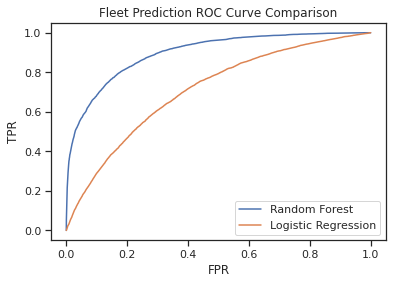

In [ ]:
preds_rf_rdd = rf_preds.select('fleet','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['fleet'])))
points_rf_rdd = CurveMetrics(preds_rf_rdd).get_curve('roc')

x_val_rf = [x[0] for x in points_rf_rdd]
y_val_rf = [x[1] for x in points_rf_rdd]
plt.plot(x_val_rf, y_val_rf, label='Random Forest')

preds_lr_rdd = lr_preds.select('fleet','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['fleet'])))
points_lr_rdd = CurveMetrics(preds_lr_rdd).get_curve('roc')

x_val_lr = [x[0] for x in points_lr_rdd]
y_val_lr = [x[1] for x in points_lr_rdd]
plt.plot(x_val_lr, y_val_lr, label='Logistic Regression')

plt.title('Fleet Prediction ROC Curve Comparison')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [ ]:
new_df = spark.read.format("csv").option("header", "true").option('inferSchema','true').load("drive/Shared drives/IST 718 Group1/spaghetti.csv")

In [ ]:
# keeping only used cars in the data
new_df = new_df.filter(new_df.is_new==0)
# Create boolean catagories for days on the market
new_df = new_df.withColumn('LongTimeOnMarket',fn.when(col('daysonmarket') < 60, 0).otherwise(1))
# modifies booleans to 1's and 0's
new_df = new_df.withColumn('HasAccidents',fn.when(col('has_accidents') == 'True', 1).otherwise(0))
new_df = new_df.drop('has_accidents')

new_df = new_df.withColumn('frameDamaged',fn.when(col('frame_damaged') == 'True', 1).otherwise(0))
new_df = new_df.drop('frame_damaged')

new_df = new_df.withColumn('franchiseDealer',fn.when(col('franchise_dealer') == 'True', 1).otherwise(0))
new_df = new_df.drop('franchise_dealer')

new_df = new_df.withColumn('isCabNew',fn.when(col('isCab') == 'True', 1).otherwise(0))
new_df = new_df.drop('isCab')

new_df = new_df.withColumn('isCpo',fn.when(col('is_cpo') == 'True', 1).otherwise(0))
new_df = new_df.drop('is_cpo')

new_df = new_df.withColumn('isOemcpo',fn.when(col('is_oemcpo') == 'True', 1).otherwise(0))
new_df = new_df.drop('is_oemcpo')

new_df = new_df.withColumn('Salvage',fn.when(col('salvage') == 'True', 1).otherwise(0))
new_df = new_df.drop('salvage')

new_df = new_df.withColumn('theftTitle',fn.when(col('theft_title') == 'True', 1).otherwise(0))
new_df = new_df.drop('theft_title')

# Create catagories for length of vehicle
new_df = new_df.withColumn('length_category',fn.when(col('length') < 176.4, "compact").when(col("length") > 187.2, "fullsize").otherwise('midsize'))

# create catagories for width of vehicle
new_df = new_df.withColumn('width_category',fn.when(col('width') < 70.9, "narrow").when(col("width") > 74.8, "wide").otherwise("regular"))

# binarizing n_fuel_type
new_df = new_df.withColumn('n_fuel_type_bin',fn.when(col('n_fuel_type') == 3, 1).otherwise(0))

# binarizing n_body_type
new_df = new_df.withColumn('n_body_type_bin',fn.when(col('n_body_type') == 6, 6).when(col("n_body_type") == 4, 4).when(col("n_body_type") == 9, 9).otherwise(0))

# binarizing n_engine_type
new_df = new_df.withColumn('n_engine_type_bin',fn.when(col('n_engine_type') == 1, 1).when(col("n_engine_type") == 4, 4).otherwise(0))

# binarizing n_transmission
new_df = new_df.withColumn('n_transmission_bin',fn.when(col('n_transmission') == 3, 3).otherwise(2))

# create catagories for owner_count
new_df = new_df.withColumn('owner_count_grp',fn.when(col('owner_count') == 1, 1).when(col("owner_count") == 2, 2).otherwise(3))

# binarizing maximum_seating
new_df = new_df.withColumn('maximum_seating_bin',fn.when(col('maximum_seating') == 5, 5).otherwise(6))

from pyspark.ml import feature, Pipeline #import modules/packages for the entire process
 
ord_cat_feat_eng_pipe = Pipeline(stages=[feature.StringIndexerModel.from_labels(['compact',
                                                                                 'midsize',
                                                                                 'fullsize'],handleInvalid = "keep",
                                                                                inputCol="length_category",
                                                                                outputCol="length_category_idx"),
                                         feature.StringIndexerModel.from_labels(['narrow',
                                                                                 'regular',
                                                                                 'wide'],
                                                                                handleInvalid = "keep",
                                                                                inputCol="width_category",
                                                                                outputCol="width_category_idx")])

car_df_xformed = ord_cat_feat_eng_pipe.fit(new_df).transform(new_df)

# Create a Pipeline to transform features
tot_feat_eng_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=['isCabNew','franchiseDealer','HasAccidents',
                                                                        "length_category_idx","width_category_idx",
                                                                        "n_body_type_bin","n_engine_type_bin",
                                                                        "n_fuel_type_bin","n_transmission_bin",
                                                                        "n_wheel_system","year", "city_fuel_economy",
                                                                        "highway_fuel_economy", "horsepower","mileage",
                                                                        "owner_count_grp", "maximum_seating_bin",
                                                                        "engine_displacement", "torque_ftlb",
                                                                        "price"],
                                                              outputCol = 'features'),
                                     feature.StandardScaler(withMean = False,
                                                            inputCol="features",
                                                            outputCol="scaledFeatures")])

car_df_xformed = tot_feat_eng_pipe.fit(car_df_xformed).transform(car_df_xformed)

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import classification

enable_grid_search = False

if enable_grid_search:
  # split samples
  training_df, validation_df, testing_df = car_df_xformed.randomSplit([0.6, 0.3, 0.1], seed=0)

  # logistic regression:
  lr = classification.LogisticRegression().setLabelCol('LongTimeOnMarket').setFeaturesCol('scaledFeatures')
      
  # parameters selected for fine-tuning using grid search
  params = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.01, 0.02]).addGrid(lr.elasticNetParam,[0.0, 0.1, 0.2]).build()

  # forming the evaluation component
  evaluator = BinaryClassificationEvaluator().setMetricName('areaUnderROC').setLabelCol('LongTimeOnMarket')
  evaluatorPR = BinaryClassificationEvaluator().setMetricName('areaUnderPR').setLabelCol('LongTimeOnMarket')

  #fittedModel = lr.fit(training_df)

  all_models = []
  all_roc = []
  all_pr = []
  for j in range(len(params)):
      print("Fitting model {}...".format(j+1))
      fittedModel = lr.fit(training_df, params[j]).transform(validation_df)
      all_models.append(fittedModel)
      all_roc.append(evaluator.evaluate(all_models[j]))
      all_pr.append(evaluatorPR.evaluate(all_models[j]))
      print("ROC score on validation data = %g" % all_roc[j])
      print("PR on validation data = %g" % all_pr[j])
  print('Concluding the best model to use:')

  print(all_roc)
  print('the best model has an ROC score of:',max(all_roc))
  print(params)
  pass

training_df, validation_df, testing_df = car_df_xformed.randomSplit([0.6, 0.3, 0.1], seed=0)

lr_best = classification.LogisticRegression().\
setLabelCol('LongTimeOnMarket').\
setFeaturesCol('scaledFeatures').\
setRegParam(0.01).\
setElasticNetParam(0.1)

lr_fit = lr_best.fit(training_df)

evaluator_best_ROC = BinaryClassificationEvaluator().setMetricName('areaUnderROC').setLabelCol('LongTimeOnMarket')
evaluator_best_PR = BinaryClassificationEvaluator().setMetricName('areaUnderPR').setLabelCol('LongTimeOnMarket')

lr_final = lr_fit.transform(validation_df)

print(evaluator_best_ROC.evaluate(lr_final))
print(evaluator_best_PR.evaluate(lr_final))

0.6102786523744597
0.3138294899914982


In [ ]:
fpr = lr_fit.summary.roc.select('FPR').toPandas()
tpr = lr_fit.summary.roc.select('TPR').toPandas()

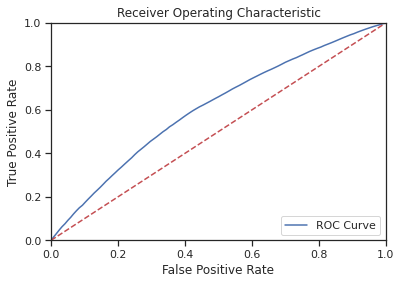

In [ ]:
# plotting the ROC
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'ROC Curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
attributes = ['isCabNew','franchiseDealer','HasAccidents',"length_category_idx","width_category_idx",
              "n_body_type_bin","n_engine_type_bin","n_fuel_type_bin","n_transmission_bin","n_wheel_system",
              "year", "city_fuel_economy", "highway_fuel_economy", "horsepower","mileage",
              "owner_count_grp", "maximum_seating_bin", "engine_displacement", "torque_ftlb", "price"]
coefficients =lr_fit.coefficients
importanceDF = pd.DataFrame({'feature' : attributes, 'coefficient' : coefficients})
importanceDF['coefficientABS'] = abs(importanceDF['coefficient'])
display(importanceDF.sort_values(by='coefficientABS', ascending=False))

,feature,coefficient,coefficientABS
1,franchiseDealer,-0.272319,0.272319
0,isCabNew,0.090214,0.090214
5,n_body_type_bin,-0.074962,0.074962
19,price,-0.067508,0.067508
4,width_category_idx,0.064292,0.064292
17,engine_displacement,-0.061376,0.061376
2,HasAccidents,0.052054,0.052054
6,n_engine_type_bin,-0.046449,0.046449
18,torque_ftlb,0.046355,0.046355
9,n_wheel_system,0.035242,0.035242
